In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.patches import Path, PathPatch
import pandas as pd
from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union, cascaded_union
from geopandas.tools import sjoin
import geopandas as gpd
from netCDF4 import Dataset
from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import ListedColormap

C:\Users\x12la\AppData\Local\Temp\ipykernel_21072\604465955.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin


In [2]:
# functions
def stats_normalized(data,prediction):
    x,y=data[~np.isnan(data)],prediction[~np.isnan(data)] # get rid of NaNs
    mu_d,mu_p = np.mean(x),np.mean(y)
    nmb = np.sum(y-x)/np.sum(x)*100
    nme = np.sum(np.abs(y-x))/np.sum(x)*100
    r,p = st.pearsonr(x,y)
    return mu_d,mu_p,nmb,nme,r,p

In [3]:
# ## Upload vehicle emission datasets
# # FIVE Measures ..
# # NOx = NO + NO2  (Harkins, C., McDonald, B. C., Henze, D. K., & Wiedinmyer, C. (2021). A fuel-based method for updating mobile source emissions during the COVID-19 pandemic. Environmental Research Letters. https://doi.org/10.1088/1748-9326/ac0660)
# # from McDonald, B. C., Goldstein, A. H., & Harley, R. A. (2015). Long-Term Trends in California Mobile Source Emissions and Ambient Concentrations of Black Carbon and Organic Aerosol. Environmental Science & Technology, 49(8), 5178–5188. https://doi.org/10.1021/es505912b
five= gpd.read_file('five_4km_cons_annual.shp') #units ton/km$^2$/hour
five_new= five.to_crs('EPSG:4326')

#LADCO setup described here:  https://doi.org/10.1029/2022JD037942
ladco =  gpd.read_file('ladco_4km_cons_annual.shp')
ladco_new= ladco.to_crs('EPSG:4326')
                      
# paper currently being written 
rowan = gpd.read_file('uvm_4km_cons_annual.shp') #units tons/km2/hour
rowan_new = rowan.to_crs('EPSG:4326')

# NEMO https://www.nature.com/articles/s41597-022-01790-9 
nemo = gpd.read_file('nemo_4km_cons_annual.shp') #units tons/km2/hour
nemo_new= nemo.to_crs('EPSG:4326')

#cook county il
cmap_cty = gpd.read_file('C:/Users/x12la/Desktop/Scripts/CMAP_cty.shp')
cmap_cty = cmap_cty.to_crs('EPSG:4326')

In [4]:
#primary roads
primary_roads = gpd.read_file('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp')
primary_roads = primary_roads.to_crs('EPSG:4326')

In [5]:
# #Clip geopandas files to chicago 
cmap_roads = gpd.clip(primary_roads, cmap_cty.to_crs('EPSG:4326'))
cmap_five = gpd.clip(five_new, cmap_cty.to_crs('EPSG:4326'))
cmap_ladco = gpd.clip(ladco_new, cmap_cty.to_crs('EPSG:4326'))
cmap_rowan = gpd.clip(rowan_new, cmap_cty.to_crs('EPSG:4326'))
cmap_nemo = gpd.clip(nemo_new, cmap_cty.to_crs('EPSG:4326'))

C:\Users\x12la\AppData\Local\Temp\ipykernel_21072\538644261.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_21072\538644261.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


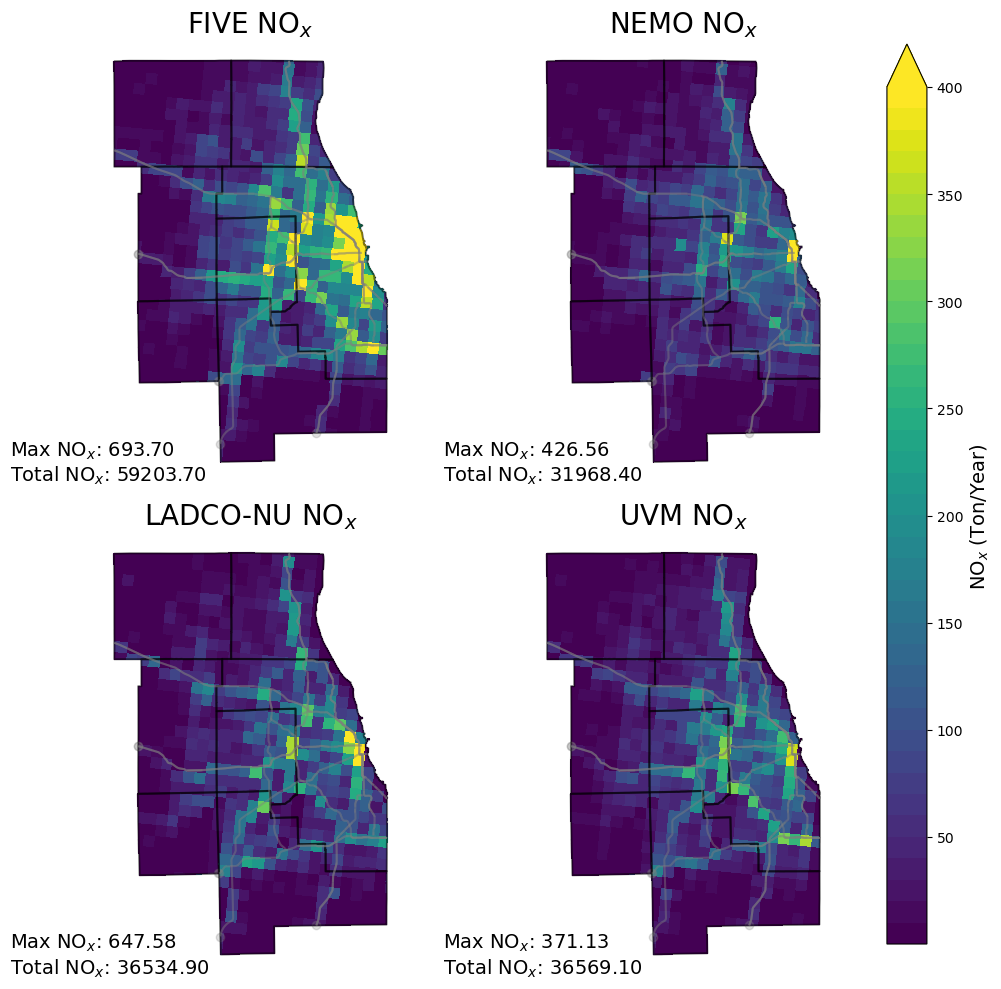

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 40))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting NOx figures with county boundaries and roads for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('NOX', ax=axs[row_index, col_index], vmax=400, cmap=cmap_discrete, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} NO$_x$', fontsize=20)
    
    # Annotate maximum NOx and domain NOx sum
    max_nox = round(cmap['NOX'].max(), 2)
    total_nox = round(cmap['NOX'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max NO$_x$: {max_nox:.2f}\nTotal NO$_x$: {total_nox:.2f}',
                                       xy=(-.3, -0.01), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('NO$_x$ (Ton/Year)', fontsize=14)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_1km_AllDatasets_2x2_discrete_colorbar_4km.png')
plt.tight_layout()
plt.show()


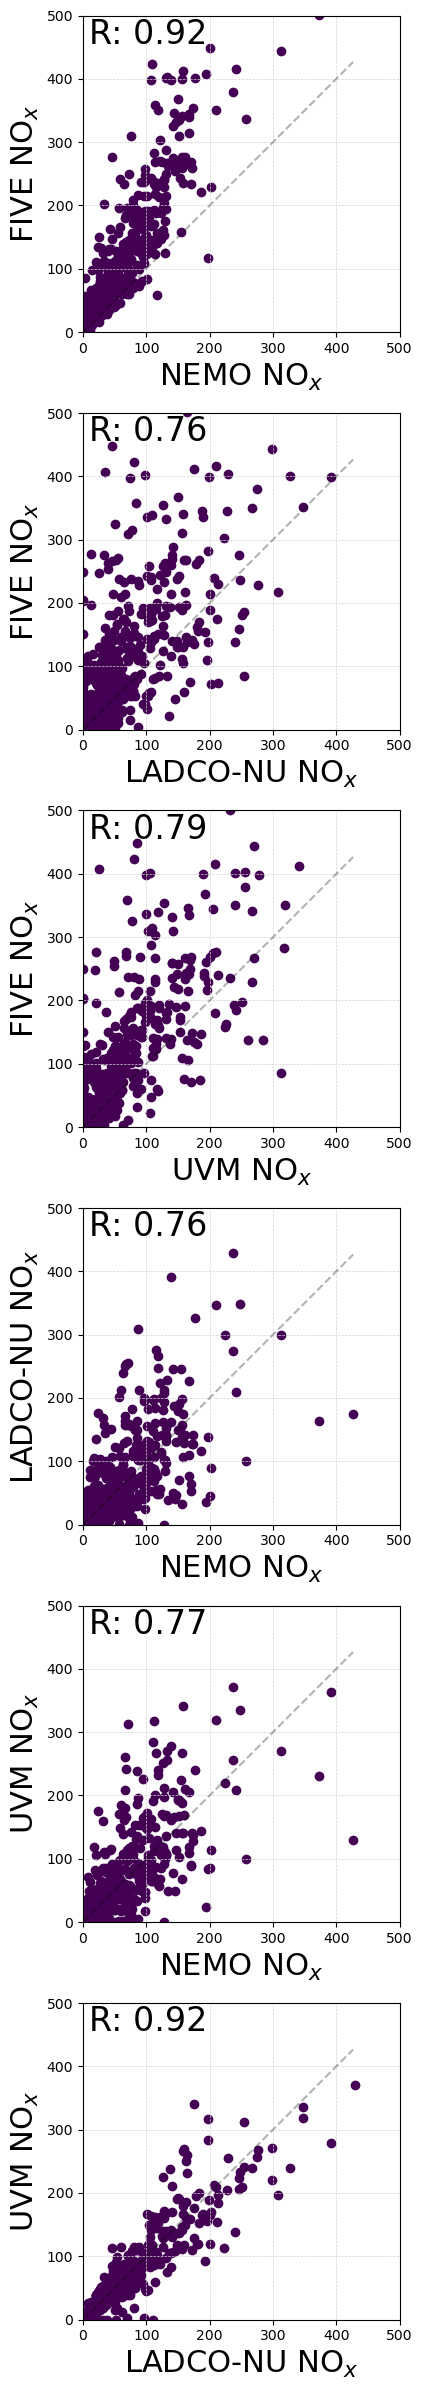

In [7]:
fig = plt.figure(figsize=(12, 24))  # Set figure size

# Subplot grid layout with 5 rows
gs = fig.add_gridspec(6, 1)

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#440154FF')  # Scatter plot
    ax.plot([x.min(), cmap_nemo['NOX'].max()], [x.min(), cmap_nemo['NOX'].max()], c='black', linestyle="--", alpha=0.3)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.91, f'R: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=24)  # Annotation for correlation coefficient
    #ax.text(0.02, 0.82, f'Y = {np.around(model.intercept_, 5)} + {np.around(model.coef_[0], 2)}X', transform=ax.transAxes, fontsize=18, color='red')  # Annotation for linear regression equation
    ax.set_xlabel(label_x, fontsize=22)  # X label
    ax.set_ylabel(label_y, fontsize=22)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=10)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 500)  # Set x limits
    ax.set_ylim(0, 500)  # Set y limits

# First subplot (correlation plot between NEMO and FIVE)
ax1 = fig.add_subplot(gs[0, 0])
x_nemo = np.array(cmap_nemo['NOX'])
y_five = np.array(cmap_five['NOX'])
plot_correlation(ax1, x_nemo, y_five, 'NEMO NO$_x$', 'FIVE NO$_x$')

# Second subplot (correlation plot between NU CCRG and FIVE)
ax2 = fig.add_subplot(gs[1, 0])
x_ladco = np.array(cmap_ladco['NOX'])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU NO$_x$', 'FIVE NO$_x$')

# Third subplot (correlation plot between UVM and FIVE)
ax3 = fig.add_subplot(gs[2, 0])
x_rowan = np.array(cmap_rowan['NOX'])
plot_correlation(ax3, x_rowan, y_five, 'UVM NO$_x$', 'FIVE NO$_x$')

# Fourth subplot (correlation plot between NEMO and NU CCRG)
ax1 = fig.add_subplot(gs[3, 0])
y_nemo = np.array(cmap_nemo['NOX'])
plot_correlation(ax1, x_nemo, x_ladco, 'NEMO NO$_x$', 'LADCO-NU NO$_x$')

# Fifth subplot (correlation plot between NEMO and UVM)
ax2 = fig.add_subplot(gs[4, 0])
plot_correlation(ax2, x_nemo, x_rowan, 'NEMO NO$_x$', 'UVM NO$_x$')

# six subplot (correlation plot between LADCO-NU and UVM)
ax3 = fig.add_subplot(gs[5, 0])
plot_correlation(ax3, x_ladco, x_rowan, 'LADCO-NU NO$_x$', 'UVM NO$_x$')

plt.tight_layout()  # Adjust layout
plt.savefig('Correlation_Plots_Column1_4km.png')  # Save figure
plt.show()  # Display figure


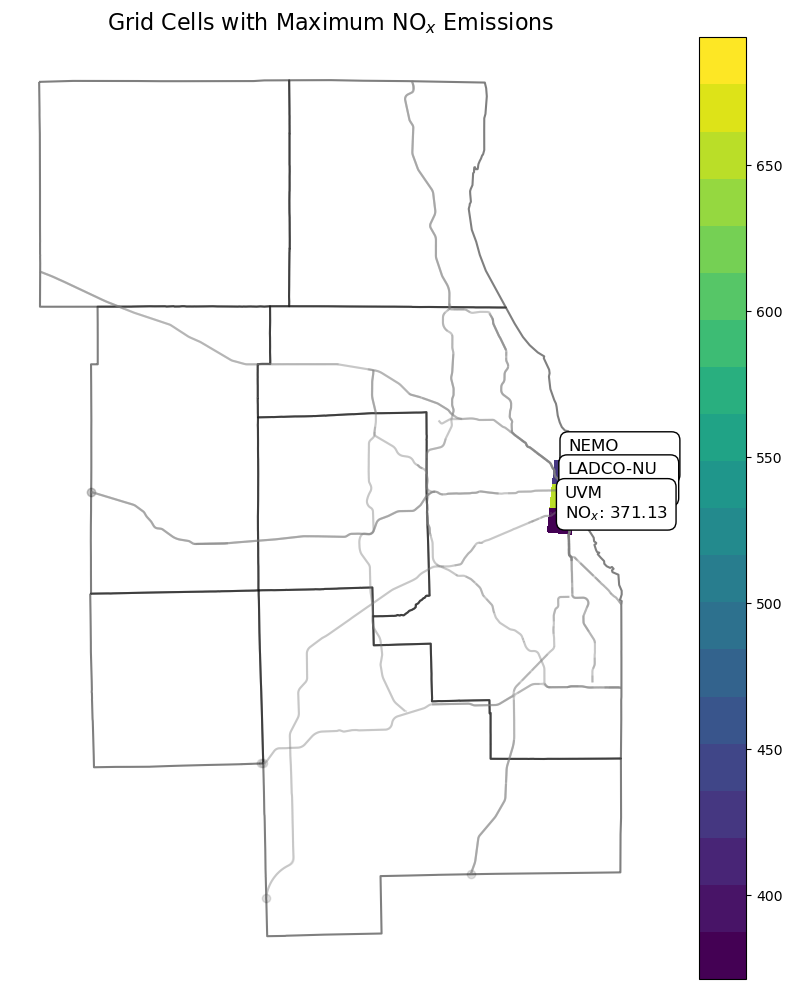

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum NOx value
def get_max_nox_row(gdf):
    return gdf.loc[gdf['NOX'].idxmax()]

# Get the row with the maximum NOx value for each dataset
max_nox_rows = [
    get_max_nox_row(cmap_five),
    get_max_nox_row(cmap_nemo),
    get_max_nox_row(cmap_ladco),
    get_max_nox_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max NOx rows
max_nox_gdf = gpd.GeoDataFrame(max_nox_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum NOx grid cells
max_nox_gdf.plot('NOX', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and NOx values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_nox_gdf.iterrows():
    label = labels[i]
    max_nox = round(row['NOX'], 2)
    ax.annotate(f'{label}\nNO$_x$: {max_nox}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum NO$_x$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis

# # Adding colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap_discrete, norm=plt.Normalize(vmin=max_nox_gdf['NOX'].min(), vmax=max_nox_gdf['NOX'].max()))
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', extend='max')
# cbar.set_label('NO$_x$ (Ton/Year)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\x12la\AppData\Local\Temp\ipykernel_21072\1206788080.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
C:\Users\x12la\AppData\Local\Temp\ipykernel_21072\1206788080.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


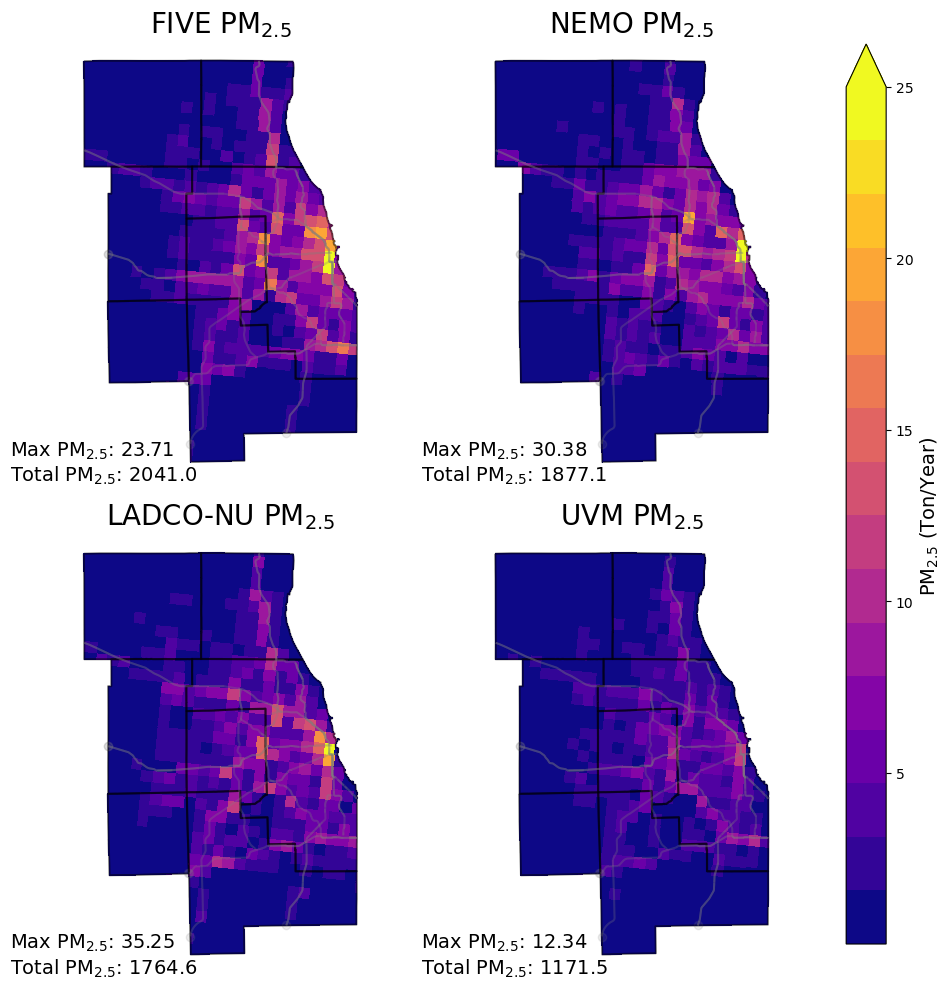

In [9]:
# Create a discrete colormap based on Viridis
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 16))  # Get 5 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(plasma_colors)

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting PM25 figures with county boundaries and roads for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('PM25', ax=axs[row_index, col_index], vmax=25, cmap=cmap_discrete, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.15)  # Add roads
    axs[row_index, col_index].set_title(f'{label} PM$_{{2.5}}$', fontsize=20)
    
    # Annotate maximum PM25 and domain PM25 sum
    max_PM25 = round(cmap['PM25'].max(), 2)
    total_PM25 = round(cmap['PM25'].sum(), 1)
    axs[row_index, col_index].annotate(f'Max PM$_{{2.5}}$: {max_PM25}\nTotal PM$_{{2.5}}$: {total_PM25}',
                                       xy=(-.2, -0.01), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='max')  # Use the first subplot's collection for the colorbar
cbar.set_label('PM$_{{2.5}}$ (Ton/Year)', fontsize=14)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_1km_AllDatasets_2x2_discrete_colorbar_4km.png')
plt.tight_layout()
plt.show()


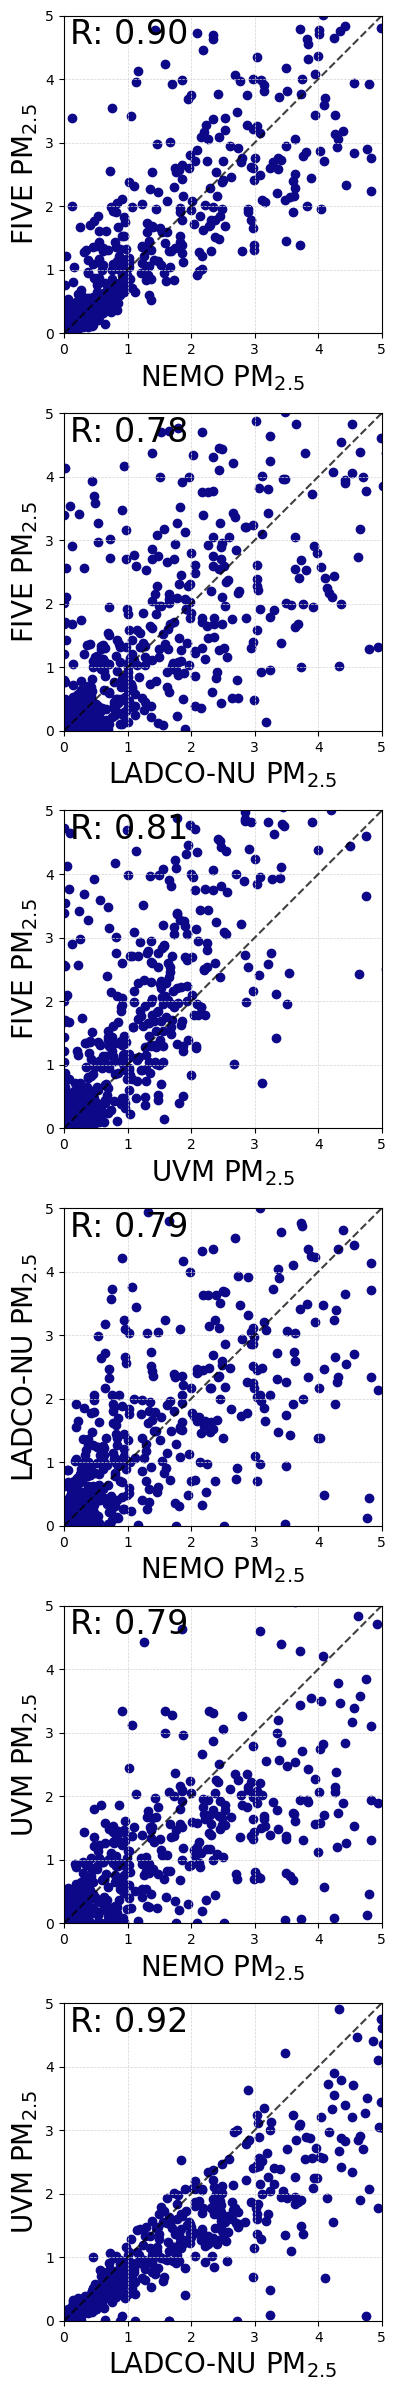

In [10]:
fig = plt.figure(figsize=(12, 24))  # Set figure size

# Subplot grid layout with 5 rows
gs = fig.add_gridspec(6, 1)

# Function to plot correlation between two datasets
def plot_correlation(ax, x, y, label_x, label_y):
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    ax.scatter(x, y, color='#0D0887FF')  # Scatter plot
    ax.plot([x.min(), cmap_nemo['PM25'].max()], [x.min(), cmap_nemo['PM25'].max()], c='black', linestyle="--", alpha=0.75)  # Diagonal line
    correlation_coefficient = np.corrcoef(x, y)[0, 1]  # Correlation coefficient
    ax.text(0.02, 0.91, f'R: {correlation_coefficient:.2f}', transform=ax.transAxes, fontsize=24)  # Annotation for correlation coefficient
    #ax.text(0.02, 0.82, f'Y = {np.around(model.intercept_, 5)} + {np.around(model.coef_[0], 2)}X', transform=ax.transAxes, fontsize=18, color='red')  # Annotation for linear regression equation
    ax.set_xlabel(label_x, fontsize=20)  # X label
    ax.set_ylabel(label_y, fontsize=20)  # Y label
    ax.tick_params(axis='both', which='major', labelsize=10)  # Tick parameters
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)  # Grid
    ax.set_aspect('equal')  # Set aspect ratio to be equal
    ax.set_xlim(0, 5)  # Set x limits
    ax.set_ylim(0, 5)  # Set y limits

# First subplot (correlation plot between NEMO and FIVE)
ax1 = fig.add_subplot(gs[0, 0])
x_nemo = np.array(cmap_nemo['PM25'])
y_five = np.array(cmap_five['PM25'])
plot_correlation(ax1, x_nemo, y_five, 'NEMO PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Second subplot (correlation plot between NU CCRG and FIVE)
ax2 = fig.add_subplot(gs[1, 0])
x_ladco = np.array(cmap_ladco['PM25'])
plot_correlation(ax2, x_ladco, y_five, 'LADCO-NU PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Third subplot (correlation plot between UVM and FIVE)
ax3 = fig.add_subplot(gs[2, 0])
x_rowan = np.array(cmap_rowan['PM25'])
plot_correlation(ax3, x_rowan, y_five, 'UVM PM$_{2.5}$', 'FIVE PM$_{2.5}$')

# Fourth subplot (correlation plot between NEMO and NU CCRG)
ax4 = fig.add_subplot(gs[3, 0])
y_nemo = np.array(cmap_nemo['PM25'])
plot_correlation(ax4, x_nemo, x_ladco, 'NEMO PM$_{2.5}$', 'LADCO-NU PM$_{2.5}$')

# Fifth subplot (correlation plot between NEMO and UVM)
ax5 = fig.add_subplot(gs[4, 0])
plot_correlation(ax5, x_nemo, x_rowan, 'NEMO PM$_{2.5}$', 'UVM PM$_{2.5}$')

# sixth subplot (correlation plot between NEMO and UVM)
ax6 = fig.add_subplot(gs[5, 0])
plot_correlation(ax6, x_ladco, x_rowan, 'LADCO-NU PM$_{2.5}$', 'UVM PM$_{2.5}$')

plt.tight_layout()  # Adjust layout
plt.savefig('PM25_Correlation_Plots_Column_4km.png')  # Save figure
plt.show()  # Display figure


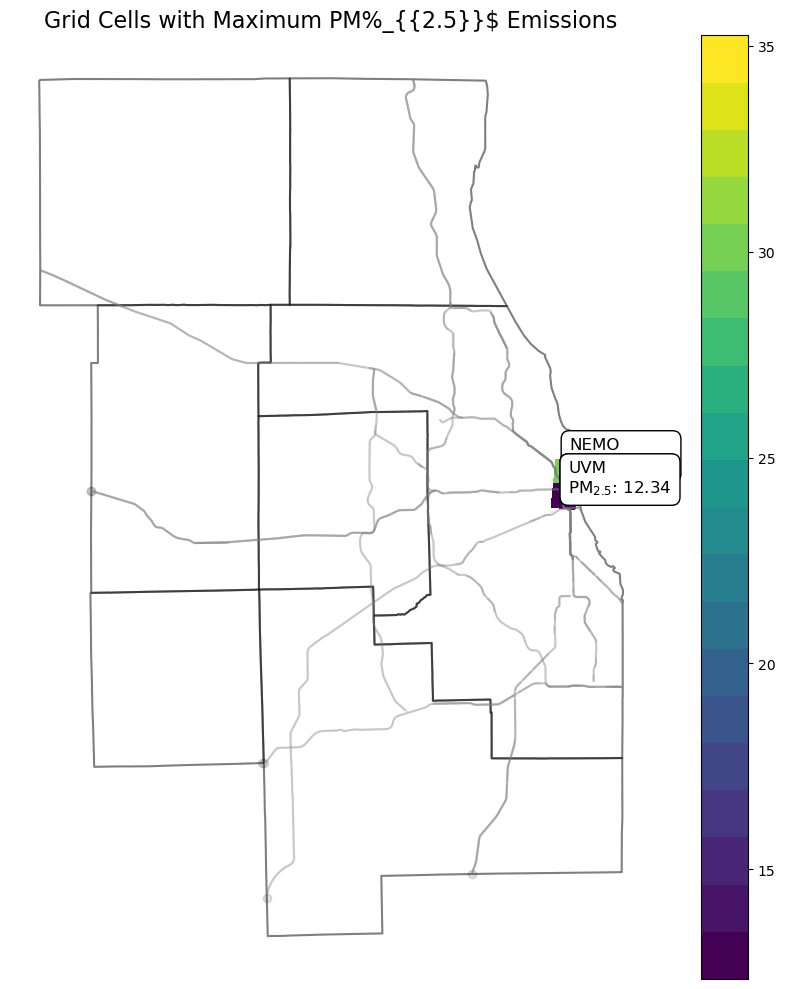

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Function to get the row with the maximum PM25 value
def get_max_PM25_row(gdf):
    return gdf.loc[gdf['PM25'].idxmax()]

# Get the row with the maximum PM25 value for each dataset
max_PM25_rows = [
    get_max_PM25_row(cmap_five),
    get_max_PM25_row(cmap_nemo),
    get_max_PM25_row(cmap_ladco),
    get_max_PM25_row(cmap_rowan)
]

# Create a new GeoDataFrame containing only the max PM25 rows
max_PM25_gdf = gpd.GeoDataFrame(max_PM25_rows, crs=cmap_five.crs).reset_index(drop=True)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the maximum PM25 grid cells
max_PM25_gdf.plot('PM25', ax=ax, cmap=cmap_discrete, legend=True, antialiased=False)

# Add county boundaries and roads to the plot
cmap_cty.boundary.plot(ax=ax, color='k', alpha=0.5)  # Add county boundaries
cmap_roads.plot(ax=ax, color='grey', alpha=0.25)  # Add roads

# Annotate the plot with the dataset labels and PM25 values
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']
for i, row in max_PM25_gdf.iterrows():
    label = labels[i]
    max_PM25 = round(row['PM25'], 2)
    ax.annotate(f'{label}\nPM$_{{2.5}}$: {max_PM25}', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords='offset points', fontsize=12, color='black',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Set title and labels
ax.set_title('Grid Cells with Maximum PM%_{{2.5}}$ Emissions', fontsize=16)
ax.set_axis_off()  # Turn off axis

# # Adding colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap_discrete, norm=plt.Normalize(vmin=max_PM25_gdf['PM25'].min(), vmax=max_PM25_gdf['PM25'].max()))
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', extend='max')
# cbar.set_label('PM%_{{2.5}}$ (Ton/Year)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


<h1> Box Whisker Plots

FIVE percentiles and mean:
  5th: 1.10
  25th: 8.94
  50th (median): 40.69
  75th: 115.65
  95th: 303.63
  mean: 82.34

NEMO percentiles and mean:
  5th: 0.21
  25th: 4.63
  50th (median): 22.01
  75th: 66.13
  95th: 151.72
  mean: 44.46

LADCO-NU percentiles and mean:
  5th: 0.18
  25th: 5.04
  50th (median): 27.00
  75th: 67.30
  95th: 187.66
  mean: 50.81

UVM percentiles and mean:
  5th: 0.00
  25th: 5.84
  50th (median): 27.39
  75th: 68.03
  95th: 192.64
  mean: 50.86



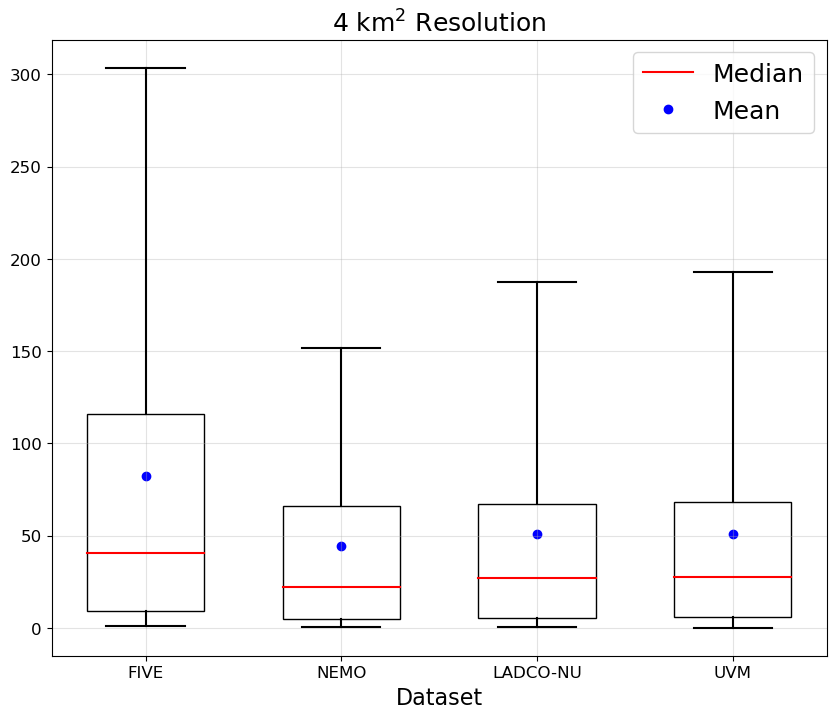

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cmap_five, cmap_nemo, cmap_ladco, and cmap_rowan are defined and contain the 'NOX' data

# Combine the NOX data from all GeoDataFrames
nox_data = [cmap_five['NOX'], cmap_nemo['NOX'], cmap_ladco['NOX'], cmap_rowan['NOX']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(nox_data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(nox_data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=16)
#plt.ylabel('NO$_X$ (Ton/Year)', fontsize=16)
plt.title('4 km$^2$ Resolution', fontsize=18)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.35)
plt.show()


FIVE percentiles and mean:
  5th: 0.04
  25th: 0.31
  50th (median): 1.35
  75th: 3.99
  95th: 10.94
  mean: 2.84

NEMO percentiles and mean:
  5th: 0.01
  25th: 0.25
  50th (median): 1.22
  75th: 3.84
  95th: 9.31
  mean: 2.61

LADCO-NU percentiles and mean:
  5th: 0.01
  25th: 0.26
  50th (median): 1.38
  75th: 3.40
  95th: 8.13
  mean: 2.45

UVM percentiles and mean:
  5th: 0.00
  25th: 0.18
  50th (median): 0.95
  75th: 2.34
  95th: 5.78
  mean: 1.63



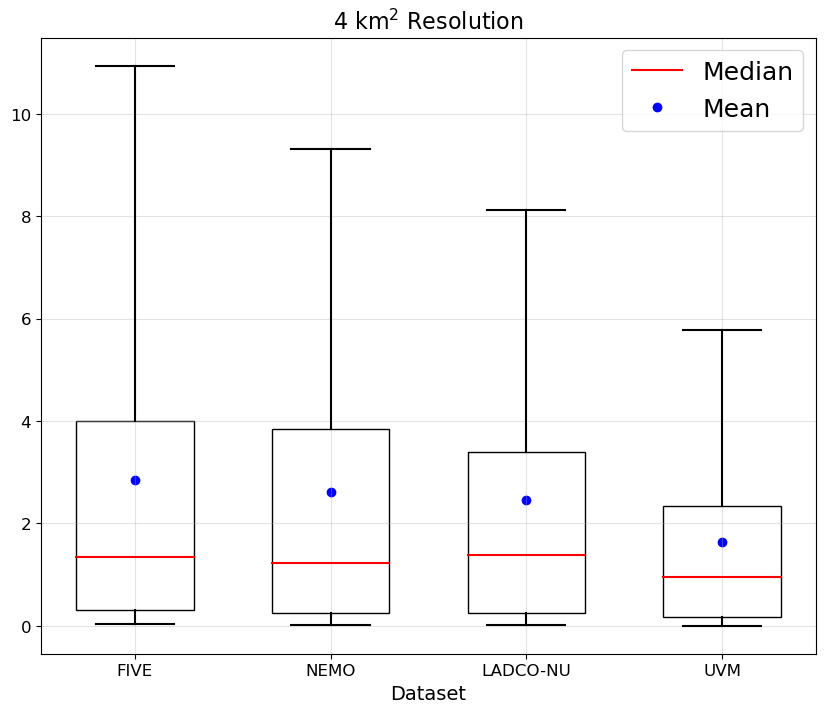

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cmap_five, cmap_nemo, cmap_ladco, and cmap_rowan are defined and contain the 'PM25' data

# Combine the PM25 data from all GeoDataFrames
PM25_data = [cmap_five['PM25'], cmap_nemo['PM25'], cmap_ladco['PM25'], cmap_rowan['PM25']]
labels = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

# Calculate percentiles and mean
percentiles = {label: {} for label in labels}
for data, label in zip(PM25_data, labels):
    percentiles[label]['5th'] = np.percentile(data, 5)
    percentiles[label]['25th'] = np.percentile(data, 25)
    percentiles[label]['50th (median)'] = np.median(data)
    percentiles[label]['75th'] = np.percentile(data, 75)
    percentiles[label]['95th'] = np.percentile(data, 95)
    percentiles[label]['mean'] = np.mean(data)

# Print out percentiles and mean for each dataset
for label, stats in percentiles.items():
    print(f"{label} percentiles and mean:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
    print()

# Create a custom box plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, data in enumerate(PM25_data, start=1):
    # Extract the required percentiles
    pct_5 = percentiles[labels[i-1]]['5th']
    pct_25 = percentiles[labels[i-1]]['25th']
    pct_50 = percentiles[labels[i-1]]['50th (median)']
    pct_75 = percentiles[labels[i-1]]['75th']
    pct_95 = percentiles[labels[i-1]]['95th']
    mean = percentiles[labels[i-1]]['mean']
    
    # Create a box plot element for each dataset
    ax.plot([i, i], [pct_5, pct_25], color='black')   # Lower whisker
    ax.plot([i, i], [pct_75, pct_95], color='black')  # Upper whisker
    ax.plot([i - 0.2, i + 0.2], [pct_5, pct_5], color='black')   # Bottom whisker cap
    ax.plot([i - 0.2, i + 0.2], [pct_95, pct_95], color='black') # Top whisker cap
    ax.add_patch(plt.Rectangle((i - 0.3, pct_25), 0.6, pct_75 - pct_25, fill=False, edgecolor='black')) # Box
    ax.plot([i - 0.3, i + 0.3], [pct_50, pct_50], color='red')  # Median line
    
    # Plot the mean
    ax.scatter(i, mean, color='blue')

# Customize the legend to include lines for median and dots for mean
median_line = plt.Line2D([], [], color='red', linestyle='-', label='Median')
mean_dot = plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='Mean')

plt.legend(handles=[median_line, mean_dot], loc='upper right', fontsize=18)

plt.xlabel('Dataset', fontsize=14)
#plt.ylabel('PM$_{{2.5}}$ (Ton/Year)', fontsize=14)
plt.title('4 km$^2$ Resolution', fontsize=16)
plt.xticks(np.arange(1, len(labels) + 1), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.35)
plt.show()


<h1> Standard deviation and mean of all 4 dataset plots

In [ ]:
cmap_ladco['NOx_sum'] = (cmap_ladco['NOX'] + cmap_rowan['NOX']  +  cmap_nemo['NOX'] +  cmap_five['NOX'])
cmap_ladco['NOx_mean'] = cmap_ladco['NOx_sum']/4

cmap_ladco['nox_std_dev'] = np.sqrt(((cmap_ladco['NOX'] - cmap_ladco['NOx_mean'])**2 + (cmap_rowan['NOX']- cmap_ladco['NOx_mean'])**2 
                                +(cmap_nemo['NOX']- cmap_ladco['NOx_mean'])**2  +  (cmap_five['NOX']- cmap_ladco['NOx_mean'])**2)/3)

In [ ]:
cmap_ladco['nox_std_dev'] = np.sqrt(((cmap_ladco['NOX'] - cmap_ladco['NOx_mean'])**2 + (cmap_rowan['NOX']- cmap_ladco['NOx_mean'])**2 
                                +(cmap_nemo['NOX']- cmap_ladco['NOx_mean'])**2  +  (cmap_five['NOX']- cmap_ladco['NOx_mean'])**2)/3)
cmap_rowan['nox_std_dev'] = cmap_ladco['nox_std_dev']
cmap_five['nox_std_dev'] = cmap_ladco['nox_std_dev']
cmap_nemo['nox_std_dev'] = cmap_ladco['nox_std_dev']

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 9))


# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

reds_colors = plt.cm.Reds(np.linspace(0, 1, 20))
cmap_reds =   ListedColormap(reds_colors)                        

# Plot the first figure
cmap_ladco.plot('NOx_mean', ax=axs[0], vmin=0, vmax=400, legend=False, cmap=cmap_discrete, 
                legend_kwds={"label": "Ton/Year", "orientation": "vertical"}, antialiased=False)
cmap_cty.boundary.plot(ax=axs[0], color='k', alpha=0.5)
cmap_roads.plot(ax=axs[0], color='k', alpha=0.05)

# Turn off the axis for the first subplot
axs[0].set_axis_off()

# Title of the first subplot
axs[0].set_title('Average Annual NO$_x$ Mean',fontsize=20)

# Annotate the first subplot with max NOx and total NOx sum
max_nox = cmap_ladco['NOx_mean'].max()
mean_nox = cmap_ladco['NOx_mean'].mean()
median_nox = cmap_ladco['NOx_mean'].median()
total_nox = cmap_ladco['NOx_mean'].sum()

# Get the coordinates for annotation
x_coord = cmap_ladco['geometry'].bounds.minx.min()
y_coord = cmap_ladco['geometry'].bounds.miny.min()

# # Annotate the first subplot
# axs[0].annotate(f"Max NO$_x$: {max_nox:.2f} Tons/Year\nNO$_x$ Domain Sum: {total_nox:.2f} Ton/Year", 
#                 xy=(x_coord, y_coord), xycoords='data',
#                 xytext=(-.100, -.050), textcoords='axes fraction',
#                 fontsize=18, horizontalalignment='left', verticalalignment='bottom')

# Plot the second figure
cmap_ladco.plot('nox_std_dev', ax=axs[1], vmin=0, vmax=400, legend=False, cmap=cmap_reds, 
                legend_kwds={"label": "Ton/Year", "orientation": "vertical"})
cmap_cty.boundary.plot(ax=axs[1], color='k', alpha=0.5)
cmap_roads.plot(ax=axs[1], color='k', alpha=0.15)

# Turn off the axis for the second subplot
axs[1].set_axis_off()

# Title of the second subplot
axs[1].set_title('Annual NO$_x$ Standard Deviation', fontsize=20)

# Annotate the second subplot with max and min values of nox_std_dev
max_nox_std_dev = cmap_ladco['nox_std_dev'].max()
min_nox_std_dev = cmap_ladco['nox_std_dev'].min()

# Get the coordinates for annotation
x_coord = cmap_ladco['geometry'].bounds.minx.min()
y_coord = cmap_ladco['geometry'].bounds.miny.min()

# # Annotate the second subplot
# axs[1].annotate(f"Max Std Dev: {max_nox_std_dev:.2f} Ton/Year", 
#                 xy=(x_coord, y_coord), xycoords='data',
#                 xytext=(-0.05, -0.05), textcoords='axes fraction',
#                 fontsize=18, horizontalalignment='left', verticalalignment='bottom')

# Create the colorbars
cbar1 = plt.colorbar(mappable=axs[0].collections[0], ax=axs[0], extend='max')
cbar2 = plt.colorbar(mappable=axs[1].collections[0], ax=axs[1], extend='max')

# Set the fontsize of the colorbar label
cbar1.ax.set_ylabel('Ton/Year', rotation=90, fontsize=18)
cbar2.ax.set_ylabel('Ton/Year', rotation=90, fontsize=18)

plt.tight_layout()
plt.savefig('NOX_4km_Mean_Std.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming cmap_five, cmap_nemo, cmap_ladco, and cmap_rowan are GeoDataFrames and contain the 'NOX' data
# Create a discrete colormap based on bwr
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 50))  # Get 40 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(viridis_colors)

# Calculate the mean of NOX for all datasets
mean_nox = (cmap_five['NOX'] + cmap_nemo['NOX'] + cmap_ladco['NOX'] + cmap_rowan['NOX']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['NOX'] - mean_nox
cmap_nemo['diff_from_mean'] = cmap_nemo['NOX'] - mean_nox
cmap_ladco['diff_from_mean'] = cmap_ladco['NOX'] - mean_nox
cmap_rowan['diff_from_mean'] = cmap_rowan['NOX'] - mean_nox

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_nox = cmap['NOX'].mean()
    sum_nox = cmap['NOX'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean NOX: {mean_nox:.2f}")
    print(f"  Sum of NOX: {sum_nox:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-250, vmax=250, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, -0.005), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the
 # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in NO$_x$ (Ton/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_Difference_From_Mean_2x2_discrete_colorbar_4km.png')
plt.show()


In [ ]:
cmap_ladco['PM25_sum'] = (cmap_ladco['PM25'] + cmap_rowan['PM25']  +  cmap_nemo['PM25'] +  cmap_five['PM25'])
cmap_ladco['PM25_mean'] = cmap_ladco['PM25_sum']/4
cmap_ladco['pm25_std_dev'] = np.sqrt(((cmap_ladco['PM25'] - cmap_ladco['PM25_mean'])**2 + (cmap_rowan['PM25']- cmap_ladco['PM25_mean'])**2 
                                +(cmap_nemo['PM25']- cmap_ladco['PM25_mean'])**2  +  (cmap_five['PM25']- cmap_ladco['PM25_mean'])**2)/3)
cmap_rowan['pm25_std_dev'] = cmap_ladco['pm25_std_dev']
cmap_five['pm25_std_dev'] = cmap_ladco['pm25_std_dev']
cmap_nemo['pm25_std_dev'] = cmap_ladco['pm25_std_dev']

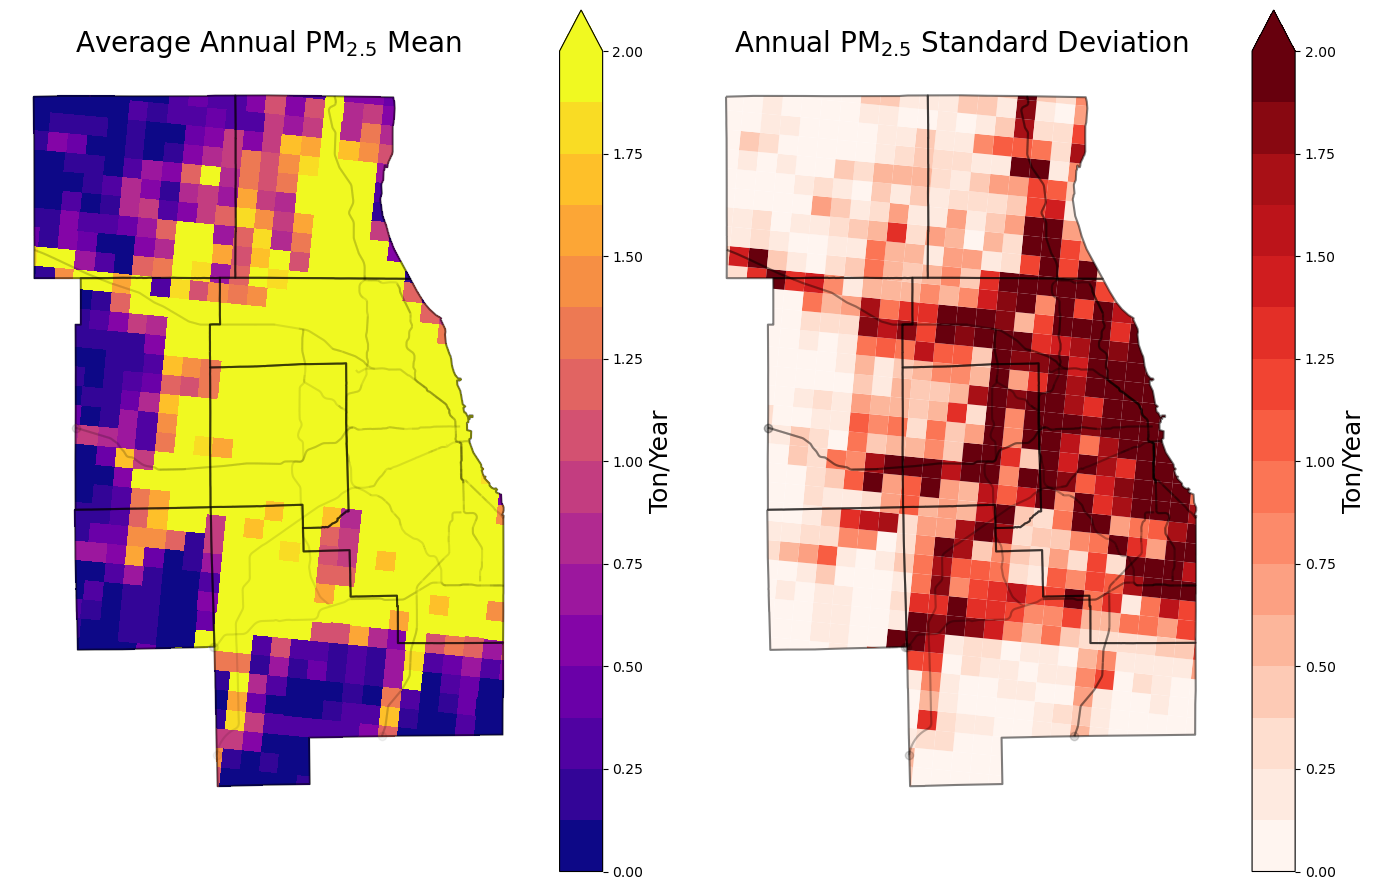

In [19]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 9))

# Create a discrete colormap based on Viridis
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 16))  # Get 5 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(plasma_colors)

reds_colors = plt.cm.Reds(np.linspace(0, 1,16))
cmap_reds =   ListedColormap(reds_colors)                        

# Plot the first figure
cmap_ladco.plot('PM25_mean', ax=axs[0], vmin=0, vmax=25, legend=False, cmap=cmap_discrete, 
                legend_kwds={"label": "Ton/Year", "orientation": "vertical"}, antialiased=False)
cmap_cty.boundary.plot(ax=axs[0], color='k', alpha=0.5)
cmap_roads.plot(ax=axs[0], color='k', alpha=0.05)

# Turn off the axis for the first subplot
axs[0].set_axis_off()

# Title of the first subplot
axs[0].set_title('Average Annual PM$_{{2.5}}$ Mean',fontsize=20)

# Annotate the first subplot with max PM25 and total PM25 sum
max_PM25 = cmap_ladco['PM25_mean'].max()
mean_PM25 = cmap_ladco['PM25_mean'].mean()
median_PM25 = cmap_ladco['PM25_mean'].median()
total_PM25 = cmap_ladco['PM25_mean'].sum()

# Get the coordinates for annotation
x_coord = cmap_ladco['geometry'].bounds.minx.min()
y_coord = cmap_ladco['geometry'].bounds.miny.min()

# # Annotate the first subplot
# axs[0].annotate(f"Max PM$_{{2.5}}$: {max_PM25:.2f} Tons/Year\nPM$_{{2.5}}$ Domain Sum: {total_PM25:.2f} Ton/Year", 
#                 xy=(x_coord, y_coord), xycoords='data',
#                 xytext=(-.100, -.050), textcoords='axes fraction',
#                 fontsize=18, horizontalalignment='left', verticalalignment='bottom')

# Plot the second figure
cmap_ladco.plot('pm25_std_dev', ax=axs[1], vmin=0, vmax=25, legend=False, cmap=cmap_reds, 
                legend_kwds={"label": "Ton/Year", "orientation": "vertical"})
cmap_cty.boundary.plot(ax=axs[1], color='k', alpha=0.5)
cmap_roads.plot(ax=axs[1], color='k', alpha=0.15)

# Turn off the axis for the second subplot
axs[1].set_axis_off()

# Title of the second subplot
axs[1].set_title('Annual PM$_{{2.5}}$ Standard Deviation', fontsize=20)

# Annotate the second subplot with max and min values of pm25_std_dev
max_pm25_std_dev = cmap_ladco['pm25_std_dev'].max()
min_pm25_std_dev = cmap_ladco['pm25_std_dev'].min()

# Get the coordinates for annotation
x_coord = cmap_ladco['geometry'].bounds.minx.min()
y_coord = cmap_ladco['geometry'].bounds.miny.min()

# Annotate the second subplot
# axs[1].annotate(f"Max Std Dev: {max_pm25_std_dev:.2f} Ton/Year", 
#                 xy=(x_coord, y_coord), xycoords='data',
#                 xytext=(-0.05, -0.05), textcoords='axes fraction',
#                 fontsize=18, horizontalalignment='left', verticalalignment='bottom')

# Create the colorbars
cbar1 = plt.colorbar(mappable=axs[0].collections[0], ax=axs[0], extend='max')
cbar2 = plt.colorbar(mappable=axs[1].collections[0], ax=axs[1], extend='max')

# Set the fontsize of the colorbar label
cbar1.ax.set_ylabel('Ton/Year', rotation=90, fontsize=18)
cbar2.ax.set_ylabel('Ton/Year', rotation=90, fontsize=18)

plt.tight_layout()
plt.savefig('PM25_4km_Mean_StdDev.png')
plt.show()

FIVE dataset:
  Max Difference: 8.06
  Min Difference: -3.82
  Mean PM25: 2.84
  Sum of PM25: 2041.05
  5th Percentile: -0.81
  25th Percentile: -0.10
  Median (50th Percentile): 0.07
  75th Percentile: 0.60
  95th Percentile: 3.28
  IQR: 0.70

NEMO dataset:
  Max Difference: 14.07
  Min Difference: -3.60
  Mean PM25: 2.61
  Sum of PM25: 1877.14
  5th Percentile: -1.04
  25th Percentile: -0.18
  Median (50th Percentile): -0.01
  75th Percentile: 0.42
  95th Percentile: 2.29
  IQR: 0.59

LADCO-NU dataset:
  Max Difference: 10.72
  Min Difference: -5.70
  Mean PM25: 2.45
  Sum of PM25: 1764.63
  5th Percentile: -1.78
  25th Percentile: -0.21
  Median (50th Percentile): 0.02
  75th Percentile: 0.39
  95th Percentile: 1.99
  IQR: 0.60

UVM dataset:
  Max Difference: 2.07
  Min Difference: -12.19
  Mean PM25: 1.63
  Sum of PM25: 1171.47
  5th Percentile: -3.28
  25th Percentile: -1.07
  Median (50th Percentile): -0.24
  75th Percentile: -0.02
  95th Percentile: 0.17
  IQR: 1.05



C:\Users\x12la\AppData\Local\Temp\ipykernel_7732\2509835647.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


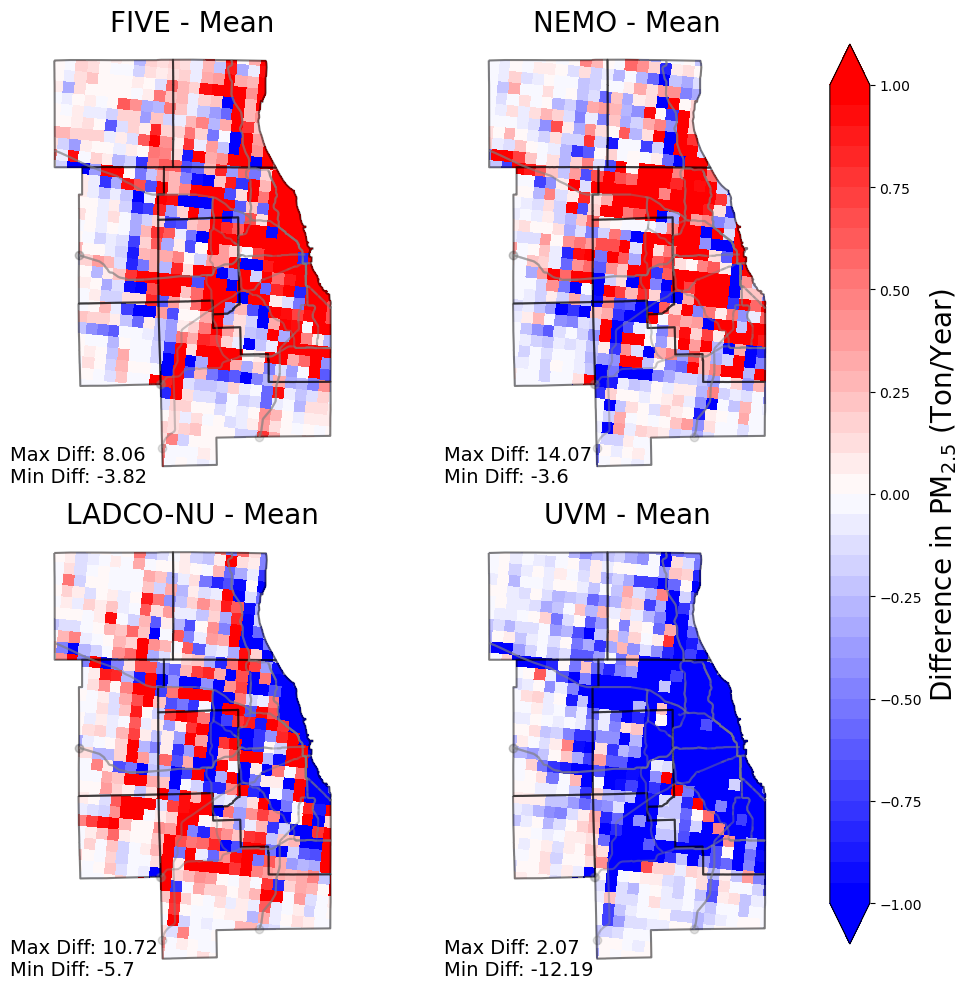

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming cmap_five, cmap_nemo, cmap_ladco, and cmap_rowan are GeoDataFrames and contain the 'PM25' data
# Create a discrete colormap based on bwr
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 40))  # Get 40 evenly spaced colors from the bwr colormap
cmap_discrete = ListedColormap(viridis_colors)

# Calculate the mean of PM25 for all datasets
mean_PM25 = (cmap_five['PM25'] + cmap_nemo['PM25'] + cmap_ladco['PM25'] + cmap_rowan['PM25']) / 4

# Calculate the difference from the mean for each dataset
cmap_five['diff_from_mean'] = cmap_five['PM25'] - mean_PM25
cmap_nemo['diff_from_mean'] = cmap_nemo['PM25'] - mean_PM25
cmap_ladco['diff_from_mean'] = cmap_ladco['PM25'] - mean_PM25
cmap_rowan['diff_from_mean'] = cmap_rowan['PM25'] - mean_PM25

# Print the maximum and minimum differences for each dataset
datasets = [('FIVE', cmap_five), ('NEMO', cmap_nemo), ('LADCO-NU', cmap_ladco), ('UVM', cmap_rowan)]
for name, cmap in datasets:
    max_diff = cmap['diff_from_mean'].max()
    min_diff = cmap['diff_from_mean'].min()
    mean_PM25 = cmap['PM25'].mean()
    sum_PM25 = cmap['PM25'].sum()

    # Calculate percentiles
    p05 = np.percentile(cmap['diff_from_mean'], 5)
    p25 = np.percentile(cmap['diff_from_mean'], 25)
    p50 = np.percentile(cmap['diff_from_mean'], 50)
    p75 = np.percentile(cmap['diff_from_mean'], 75)
    p95 = np.percentile(cmap['diff_from_mean'], 95)
    iqr = p75 - p25

    print(f"{name} dataset:")
    print(f"  Max Difference: {max_diff:.2f}")
    print(f"  Min Difference: {min_diff:.2f}")
    print(f"  Mean PM25: {mean_PM25:.2f}")
    print(f"  Sum of PM25: {sum_PM25:.2f}")
    print(f"  5th Percentile: {p05:.2f}")
    print(f"  25th Percentile: {p25:.2f}")
    print(f"  Median (50th Percentile): {p50:.2f}")
    print(f"  75th Percentile: {p75:.2f}")
    print(f"  95th Percentile: {p95:.2f}")
    print(f"  IQR: {iqr:.2f}")
    print()

# Create subplots with 2 rows and 2 columns and larger figsize
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting the difference from mean for the subplots
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    cmap, label = cmap_data
    cmap.plot('diff_from_mean', ax=axs[row_index, col_index], cmap=cmap_discrete, vmin=-10, vmax=10, legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row_index, col_index], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row_index, col_index], color='grey', alpha=0.25)  # Add roads
    axs[row_index, col_index].set_title(f'{label} - Mean', fontsize=20)
    
    # Annotate maximum and minimum difference
    max_diff = round(cmap['diff_from_mean'].max(), 2)
    min_diff = round(cmap['diff_from_mean'].min(), 2)
    axs[row_index, col_index].annotate(f'Max Diff: {max_diff}\nMin Diff: {min_diff}',
                                       xy=(-.1, 0), xycoords='axes fraction',
                                       fontsize=14, ha='left', va='bottom')

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05)  # Decrease wspace for less whitespace

# Adding a single colorbar to the right of all figures
cbar_ax = fig.add_axes([0.92, 0.05, 0.04, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', extend='both')  # Use the first subplot's collection for the
 # Use the first subplot's collection for the colorbar
cbar.set_label('Difference in PM$_{{2.5}}$ (Ton/Year)', fontsize=20)

# Turn off axis for all subplots
for ax in axs.flat:
    ax.set_axis_off()

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('PM25_Difference_From_Mean_2x2_discrete_colorbar_4km.png')
plt.show()
